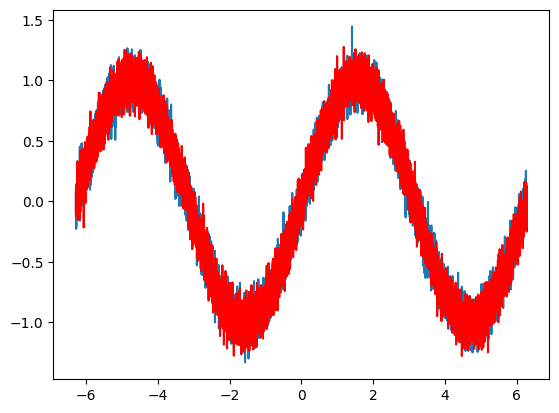

In [3]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy

def f(x):
    return np.sin(x) + 0.1*np.random.randn(len(x))

# target_function parameters
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency
def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

def plot_function(f, x_min=-2*np.pi, x_max=2*np.pi, n_points=10000, predicted=None):
    x = np.linspace(x_min, x_max, n_points)
    y = f(x)
    plt.plot(x, y)
    if predicted is not None:
        predicted = predicted(x)
        plt.plot(x, predicted, label='Predicted', color='red')
    plt.show()

#plot_function(lambda x: np.sin(x) * np.cos(2*x)/2*np.sin(x))
#plot_function(lambda x: np.sin(x) + 0.1*np.random.randn(len(x)))
plot_function(lambda x: f(x), predicted=lambda x: np.sin(x) + 0.1*np.random.randn(len(x)))

#(lambda x: f(x), predicted=lambda x: np.sin(x) + numpy.random.randn() * 0.1)
#plot_function(lambda x: target_function(x))
#plot_function(lambda x: np.sin(x) + 0.1*np.random.randn(len(x)))

0: ──Rot(4.20,6.20,4.70)─╭●───────╭X─┤  <I>
1: ──Rot(5.80,1.39,5.75)─╰X─╭●────│──┤     
2: ──Rot(4.22,4.83,3.75)────╰X─╭●─│──┤     
3: ──Rot(6.07,3.23,6.17)───────╰X─╰●─┤     


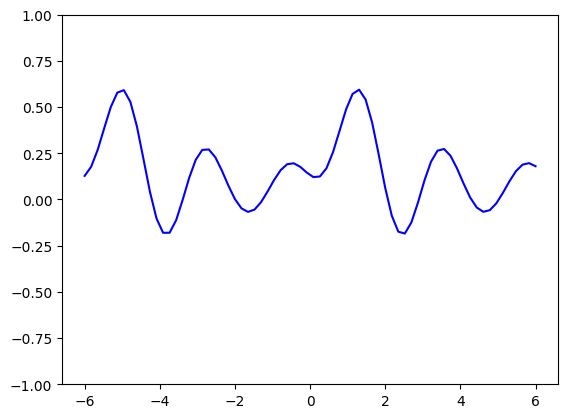

In [103]:
import pennylane as qml

n_ansatz_layers = 1
n_qubits = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def ansatz(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ = 2 * np.pi * np.random.random(size=(n_ansatz_layers, n_qubits, 3))
print(qml.draw(ansatz, expansion_strategy="device")(weights_))



def S(x, scaling=1.0):
    """Data-encoding circuit block."""
    for w in range(n_qubits):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    qml.StronglyEntanglingLayers(theta, wires=range(n_qubits))


@qml.qnode(dev)
def parallel_circuit(weights, x):
    
    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

trainable_block_layers = 3
weights = 2 * np.pi * np.random.random(size=(2, trainable_block_layers, n_qubits, 3), requires_grad=True)

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [parallel_circuit(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show();

In [105]:
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

def cost(weights, x, y):
    predictions = [parallel_circuit(weights, x_) for x_ in x]
    return square_loss(y, predictions)

x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([target_function(x) for x_ in x], requires_grad=False)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.